In [1]:
import re
import json
import pandas as pd
from pathlib import Path
from qwen_math_parser import extract_answer, strip_string
from grader import math_equal
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Accuracy

## MATH500

In [11]:
result_df = pd.read_csv(Path.cwd().parent / "results" / "merged_accuracy.csv")

In [46]:
result_df.method.unique()

array(['forward-pass', 'kl-divergence', 'majority-vote'], dtype=object)

In [26]:
forward_pass_summary_df = (
    result_df[result_df.method == "forward-pass"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

In [36]:
majority_vote_df = (
    result_df[result_df.method == "majority-vote"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

In [50]:
kl_divergences_df = (
    result_df[result_df.method == "kl-divergence"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

In [59]:
result_df[result_df.model_id == "meta-llama/Llama-3.2-1B-Instruct"]

,method,model_id,dataset,n_samples,file_path,model_response,response_number,expected_answer,model_output,accuracy,n_question,n_reasoning_steps
11976,forward-pass,meta-llama/Llama-3.2-1B-Instruct,math500,1,493results.json,<|begin_of_text|><|begin_of_text|><|start_head...,0,20,+b+25+0+25=50Thefinalansweris:\boxed{50}<|eot_...,False,493,1
11977,forward-pass,meta-llama/Llama-3.2-1B-Instruct,math500,1,493results.json,<|begin_of_text|><|begin_of_text|><|start_head...,1,20,answer,False,493,1
11978,forward-pass,meta-llama/Llama-3.2-1B-Instruct,math500,1,493results.json,<|begin_of_text|><|begin_of_text|><|start_head...,2,20,38,False,493,1
11979,forward-pass,meta-llama/Llama-3.2-1B-Instruct,math500,1,493results.json,<|begin_of_text|><|begin_of_text|><|start_head...,3,20,107,False,493,1
11980,forward-pass,meta-llama/Llama-3.2-1B-Instruct,math500,1,493results.json,<|begin_of_text|><|begin_of_text|><|start_head...,4,20,11,False,493,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75576,majority-vote,meta-llama/Llama-3.2-1B-Instruct,gsm8k-da,8,38results.json,<|begin_of_text|><|begin_of_text|><|start_head...,1,4,answer,False,38,1
75577,majority-vote,meta-llama/Llama-3.2-1B-Instruct,gsm8k-da,8,38results.json,<|begin_of_text|><|begin_of_text|><|start_head...,2,4,answer,False,38,1
75578,majority-vote,meta-llama/Llama-3.2-1B-Instruct,gsm8k-da,8,38results.json,<|begin_of_text|><|begin_of_text|><|start_head...,3,4,answer,False,38,1
75579,majority-vote,meta-llama/Llama-3.2-1B-Instruct,gsm8k-da,8,38results.json,<|begin_of_text|><|begin_of_text|><|start_head...,4,4,answer,False,38,1


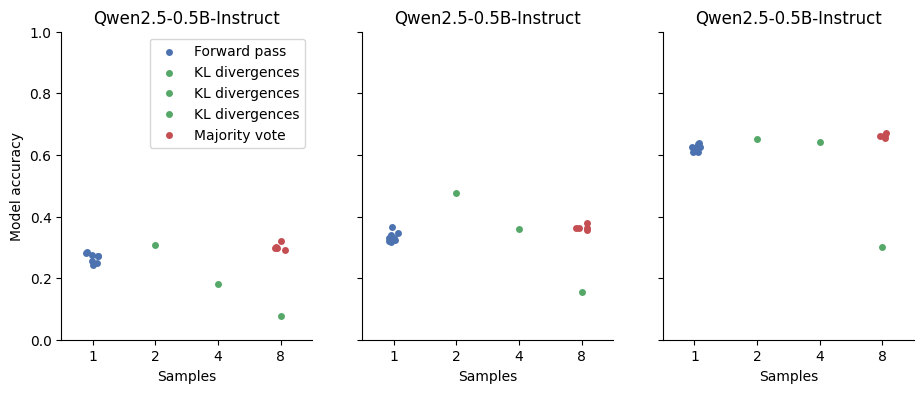

In [53]:
fig, ax = plt.subplots(figsize=(11, 4), ncols=3, sharey=True)
for i, model_id in enumerate(
    [
        "Qwen/Qwen2.5-0.5B-Instruct",
        "Qwen/Qwen2.5-1.5B-Instruct",
        "Qwen/Qwen2.5-3B-Instruct",
    ]
):
    # Forward pass
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#4c72b0",
        data=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Forward pass",
    )

    # KL divergences
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#55a868",
        data=kl_divergences_df[
            (kl_divergences_df.model_id == model_id)
            & (kl_divergences_df.dataset == "math500")
        ],
        ax=ax[i],
        label="KL divergences",
    )

    # Majority vote
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#c44e52",
        data=majority_vote_df[
            (majority_vote_df.model_id == model_id)
            & (majority_vote_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Majority vote",
    )
    ax[i].set(title=model, ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

for i in range(1, 3):
    ax[i].legend_.remove()

sns.despine()

plt.savefig(
    Path.cwd().parent / "figures" / "figure_1.pdf", bbox_inches="tight", dpi=300
)

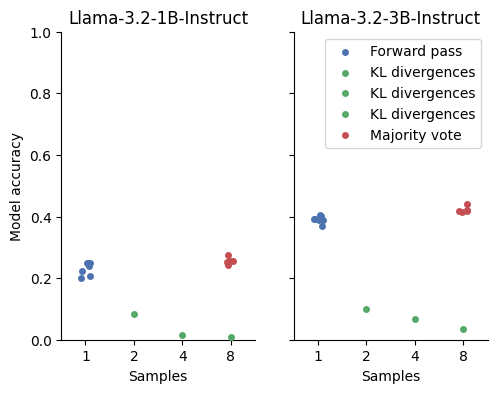

In [56]:
fig, ax = plt.subplots(figsize=(5.5, 4), ncols=2, sharey=True)
for i, model_id in enumerate(
    [
        "meta-llama/Llama-3.2-1B-Instruct",
        "meta-llama/Llama-3.2-3B-Instruct",
    ]
):
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#4c72b0",
        data=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Forward pass",
    )

    # KL divergences
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#55a868",
        data=kl_divergences_df[
            (kl_divergences_df.model_id == model_id)
            & (kl_divergences_df.dataset == "math500")
        ],
        ax=ax[i],
        label="KL divergences",
    )

    # Majority vote
    plot = sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="#c44e52",
        data=majority_vote_df[
            (majority_vote_df.model_id == model_id)
            & (majority_vote_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Majority vote",
    )
    ax[i].set(title=model_id[11:], ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

for i in range(1, 2):
    ax[0].legend_.remove()

sns.despine()

plt.savefig(
    Path.cwd().parent / "figures" / "figure_2.pdf", bbox_inches="tight", dpi=300
)

# GSM8K

## Accuracy

In [6]:
result_df.groupby(["method", "model", "n_samples", "dataset"], as_index=False)[
    "accuracy"
].count()

,method,model,n_samples,dataset,accuracy
0,forward-pass,Llama-3.2-1B-Instruct,1,gsm8k-da,99
1,forward-pass,Llama-3.2-1B-Instruct,1,gsm8k-en,99
2,forward-pass,Llama-3.2-1B-Instruct,1,math500,499
3,forward-pass,Llama-3.2-3B-Instruct,1,gsm8k-da,99
4,forward-pass,Llama-3.2-3B-Instruct,1,gsm8k-en,99
...,...,...,...,...,...
70,kl-divergence,Qwen2.5-7B-Instruct,8,gsm8k-en,99
71,kl-divergence,Qwen2.5-7B-Instruct,8,math500,499
72,self-consistency,Qwen2.5-0.5B-Instruct,2,math500,499
73,self-consistency,Qwen2.5-0.5B-Instruct,4,math500,499


In [7]:
summary_df = result_df.groupby(
    ["method", "model", "n_samples", "dataset"], as_index=False
)["accuracy"].mean()
summary_df = summary_df[summary_df.dataset.isin(["gsm8k-en", "gsm8k-da"])]

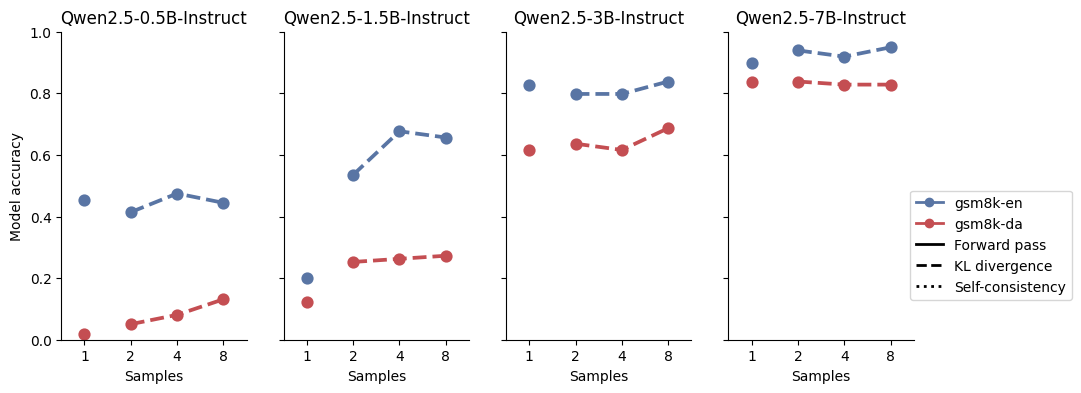

In [8]:
fig, ax = plt.subplots(figsize=(11, 4), ncols=4, sharey=True)
for i, model in enumerate(
    [
        "Qwen2.5-0.5B-Instruct",
        "Qwen2.5-1.5B-Instruct",
        "Qwen2.5-3B-Instruct",
        "Qwen2.5-7B-Instruct",
    ]
):
    for dataset, color in zip(["gsm8k-en", "gsm8k-da"], ["#5975a4", "#c44e52"]):
        for method, linestyle in zip(
            ["forward-pass", "kl-divergence", "self-consistency"], ["-", "--", ":"]
        ):
            plot = sns.pointplot(
                x="n_samples",
                y="accuracy",
                color=color,
                linestyles=linestyle,
                data=summary_df[
                    (summary_df.model == model)
                    & (summary_df.dataset == dataset)
                    & (summary_df.method == method)
                ],
                ax=ax[i],
            )
    ax[i].set(title=model, ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

legend_elements = [
    Line2D([0], [0], marker="o", color="#5975a4", lw=2, label="gsm8k-en"),
    Line2D([0], [0], marker="o", color="#c44e52", lw=2, label="gsm8k-da"),
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="Forward pass"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="KL divergence"),
    Line2D([0], [0], color="black", lw=2, linestyle=":", label="Self-consistency"),
]

fig.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.05, 0.5),
)
sns.despine()
plt.savefig("figure_2.pdf", bbox_inches="tight", dpi=300)

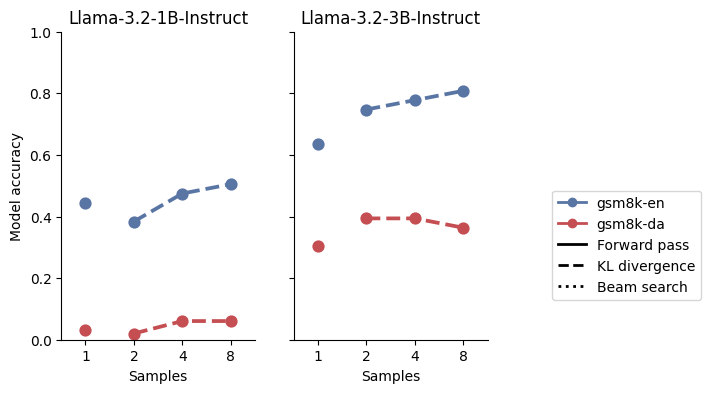

In [9]:
fig, ax = plt.subplots(figsize=(5.5, 4), ncols=2, sharey=True)
for i, model in enumerate(
    [
        "Llama-3.2-1B-Instruct",
        "Llama-3.2-3B-Instruct",
    ]
):
    for dataset, color in zip(["gsm8k-en", "gsm8k-da"], ["#5975a4", "#c44e52"]):
        for method, linestyle in zip(
            ["forward-pass", "kl-divergence", "beam-search"], ["-", "--", ":"]
        ):
            plot = sns.pointplot(
                x="n_samples",
                y="accuracy",
                color=color,
                linestyles=linestyle,
                data=summary_df[
                    (summary_df.model == model)
                    & (summary_df.dataset == dataset)
                    & (summary_df.method == method)
                ],
                ax=ax[i],
            )
    ax[i].set(title=model, ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

legend_elements = [
    Line2D([0], [0], marker="o", color="#5975a4", lw=2, label="gsm8k-en"),
    Line2D([0], [0], marker="o", color="#c44e52", lw=2, label="gsm8k-da"),
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="Forward pass"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="KL divergence"),
    Line2D([0], [0], color="black", lw=2, linestyle=":", label="Beam search"),
]

fig.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.3, 0.5),
)
sns.despine()
plt.savefig("figure_2.pdf", bbox_inches="tight", dpi=300)